In [16]:
import os
import cv2
import time
import pytz
import pickle
import psutil
import imutils
import datetime
import xlsxwriter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
from tabulate import tabulate
from openpyxl import load_workbook

In [18]:
img_test_path = r"C:\Users\SMSK_Narinda\Desktop\Research\Random_Test_Images"

In [19]:
#Array for saving in excel
img_num = []
img_name = []
memory_usage = []
time_taken = []
prediction = []

In [20]:
timezone = pytz.timezone("Asia/Jakarta")
now = timezone.localize(datetime.datetime.now())

In [21]:
print(timezone)
print(now)

Asia/Jakarta
2024-07-07 18:53:50.986956+07:00


# Testing KNN

In [8]:
# Load model KNN
KNNclf = r"C:\Users\SMSK_Narinda\Desktop\Skripsi_Checkpoint_KNN_SVM_Dermnet\Model\KNNClassifier.p"
modelKNN = pickle.load(open( KNNclf ,'rb'))

In [9]:
def extract_color_histogram(image, bins=(32,32,32)):
    # Extract 3d color by its hue, saturation, and vue (HSV)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins,
                       [0, 180, 0 , 256, 0, 256])
    
    ### handle normalizing the historigram
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else :
        cv2.normalize(hist,hist)
        
    return hist.flatten()

In [10]:
print('[START]')

for idx, filename in enumerate(os.scandir(img_test_path)):
    if filename.is_file():
        print("Testing image number: ", idx+1)
        # Store image number and filename
        img_num.append(idx + 1)
        img_name.append(filename.name)
        
        # Get image's path from object filename
        image_path = filename.path
        
        # Read image from image_path 
        image = cv2.imread(image_path)
        
        # Resize image to the desired size
        image = cv2.resize(image, (128, 128))
        
        # Extract features using color histogram
        features = extract_color_histogram(image)
        
        # Measure memory and time for prediction
        current_process = psutil.Process(os.getpid())
        mem_start = current_process.memory_info().rss
        start_time = time.time()
        
        # Perform predictio
        predict = modelKNN.predict([features])
        prediction.append(predict)
        
        end_time = time.time()
        mem_end = current_process.memory_info().rss

        print("memori awal: ", mem_start)
        print("memori akhir: ", mem_end)
        
        memory_usage.append((mem_end - mem_start) / 1024)  # Memory usage in KB
        time_taken.append(end_time - start_time)  # Time taken in seconds

# Calculate average memory and time
avg_memory = sum(memory_usage) / len(memory_usage) if memory_usage else 0
avg_time = sum(time_taken) / len(time_taken) if time_taken else 0

print('[STOP]')
print("Testing completed.")
print("")
print("[RESULT]")
print(f'Average memory used per image: {avg_memory:.2f} KB')
print(f'Average time taken per image: {avg_time:.2f} seconds')

[START]
Testing image number:  1
memori awal:  12625534976
memori akhir:  12630319104
Testing image number:  2
memori awal:  12630323200
memori akhir:  12629159936
Testing image number:  3
memori awal:  12630179840
memori akhir:  12630532096
Testing image number:  4
memori awal:  12630470656
memori akhir:  12630740992
Testing image number:  5
memori awal:  12630740992
memori akhir:  12629487616
Testing image number:  6
memori awal:  12629549056
memori akhir:  12630306816
Testing image number:  7
memori awal:  12630343680
memori akhir:  12629508096
Testing image number:  8
memori awal:  12630540288
memori akhir:  12630552576
Testing image number:  9
memori awal:  12628459520
memori akhir:  12630544384
Testing image number:  10
memori awal:  12630282240
memori akhir:  12630315008
Testing image number:  11
memori awal:  12629262336
memori akhir:  12628987904
Testing image number:  12
memori awal:  12630011904
memori akhir:  12630269952
Testing image number:  13
memori awal:  12630269952
m

# Testing SVM

In [25]:
# Load model SVM
SVMclf = r"C:\Users\SMSK_Narinda\Desktop\Skripsi_Checkpoint_KNN_SVM_Dermnet\Model\SVM_71_Classifier.p"
modelSVM = pickle.load(open( SVMclf ,'rb'))

In [26]:
# Load Label
datadir= r"C:\Users\SMSK_Narinda\Desktop\Research\dataset"

In [27]:
Categories=[]

subfolders= [os.path.join(datadir, d) for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]
for label in os.listdir(datadir):
    Categories.append(label)

In [28]:
# Preprocessing SVM
def transform_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    return np.array([label_mapping[label] for label in labels]), label_mapping

# def inverse_transform_labels(predictions, label_mapping):
#     inverse_mapping = {v: k for k, v in label_mapping.items()}
#     return np.array([inverse_mapping[int(round(pred))] for pred in predictions])

def inverse_transform_labels(predictions, label_mapping):
    inverse_mapping = {v: k for k, v in label_mapping.items()}
    transformed_labels = []
    for pred in predictions:
        rounded_pred = int(round(pred))
        if rounded_pred in inverse_mapping:
            transformed_labels.append(inverse_mapping[rounded_pred])
        else:
            print(f"Unexpected prediction value: {rounded_pred}")
            transformed_labels.append("Unknown")  # Or handle it appropriately
    return np.array(transformed_labels)

In [29]:
# Transformasi label
labels_train_transformed, label_mapping = transform_labels(Categories)

In [33]:
print("Label Mapping:", label_mapping)

Label Mapping: {'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Bullous Disease Photos': 3, 'Cellulitis Impetigo and other Bacterial Infections': 4, 'Eczema Photos': 5, 'Exanthems and Drug Eruptions': 6, 'Hair Loss Photos Alopecia and other Hair Diseases': 7, 'Herpes HPV and other STDs Photos': 8, 'Light Diseases and Disorders of Pigmentation': 9, 'Lupus and other Connective Tissue diseases': 10, 'Melanoma Skin Cancer Nevi and Moles': 11, 'Nail Fungus and other Nail Disease': 12, 'Poison Ivy Photos and other Contact Dermatitis': 13, 'Psoriasis pictures Lichen Planus and related diseases': 14, 'Scabies Lyme Disease and other Infestations and Bites': 15, 'Seborrheic Keratoses and other Benign Tumors': 16, 'Systemic Disease': 17, 'Tinea Ringworm Candidiasis and other Fungal Infections': 18, 'Urticaria Hives': 19, 'Vascular Tumors': 20, 'Vasculitis Photos': 21, 'Warts Molluscum and other Viral Infections

In [31]:
print('[START]')

for idx, filename in enumerate(os.scandir(img_test_path)):
    if filename.is_file():
        print("Testing image number: ", idx+1)
        # Store image number and filename
        img_num.append(idx + 1)
        img_name.append(filename.name)
        
        # Get image's path from object filename
        image_path = filename.path
        
        # Read image from image_path 
        image = cv2.imread(image_path)
        
        # Resize image to the desired size
        image = cv2.resize(image, (150, 150))
        image = image.flatten()
        image = np.array(image)
        
        # Measure memory and time for prediction
        current_process = psutil.Process(os.getpid())
        mem_start = current_process.memory_info().rss
        start_time = time.time()
        
        # Perform predictio
        predictions = modelSVM.predict([image])
        predicted_labels = inverse_transform_labels(predictions, label_mapping)
        prediction.append(predicted_labels)
        
        end_time = time.time()
        mem_end = current_process.memory_info().rss

        print("memori awal: ", mem_start)
        print("memori akhir: ", mem_end)
        
        memory_usage.append((mem_end - mem_start) / 1024)  # Memory usage in KB
        time_taken.append(end_time - start_time)  # Time taken in seconds

# Calculate average memory and time
avg_memory = sum(memory_usage) / len(memory_usage) if memory_usage else 0
avg_time = sum(time_taken) / len(time_taken) if time_taken else 0

print('[STOP]')
print("Testing completed.")
print("")
print("[RESULT]")
print(f'Average memory used per image: {avg_memory:.2f} KB')
print(f'Average time taken per image: {avg_time:.2f} seconds')

[START]
Testing image number:  1
memori awal:  15090405376
memori akhir:  15090479104
Testing image number:  2
memori awal:  15090479104
memori akhir:  15090479104
Testing image number:  3
memori awal:  15090479104
memori akhir:  15090479104
Testing image number:  4
memori awal:  15090442240
memori akhir:  15090442240
Testing image number:  5
memori awal:  15091482624
memori akhir:  15091482624
Testing image number:  6
memori awal:  15089442816
memori akhir:  15089442816
Testing image number:  7
memori awal:  15090462720
memori akhir:  15090462720
Testing image number:  8
memori awal:  15090462720
memori akhir:  15090462720
Testing image number:  9
memori awal:  15090462720
memori akhir:  15090462720
Testing image number:  10
memori awal:  15090462720
memori akhir:  15090462720
Testing image number:  11
memori awal:  15089442816
memori akhir:  15089442816
Testing image number:  12
memori awal:  15090466816
memori akhir:  15090466816
Testing image number:  13
memori awal:  15090466816
m

# Hasil Analisis

In [34]:
print(f'Summary of Memory Usage: {sum(memory_usage)} KB')
print(f'Summary of Duration: {sum(time_taken)} seconds')

Summary of Memory Usage: 72.0 KB
Summary of Duration: 48.033674478530884 seconds


In [35]:
# Information prints
# Prepare data for tabulate
table_data = [["No.", "Filename", "Memory usage", "Time taken"],
              *zip(range(1, len(memory_usage) + 1), img_name, memory_usage, time_taken)]

# Print table using tabulate, with transposed data
print(tabulate(table_data, headers="firstrow", tablefmt="plain"))


  No.  Filename                                    Memory usage    Time taken
    1  03Eczema0310.jpg                                      72      0.47603
    2  03EczemaAreolae021223.jpg                              0      0.469638
    3  03EczemaAreolae1.jpg                                   0      0.490669
    4  08lichenPlanusTongue112205.jpg                         0      0.476028
    5  08lichenPlanusTongue1122051.jpg                        0      0.492622
    6  08lichenPlanusTongue1122052.jpg                        0      0.479937
    7  08LSAAnal062804.jpg                                    0      0.480912
    8  08LSASkin.jpg                                          0      0.469206
    9  acne-keloidalis-25.jpg                                 0      0.460859
   10  acne-keloidalis-26.jpg                                 0      0.462367
   11  actinic-cheilitis-sq-cell-lip-3.jpg                    0      0.476042
   12  actinic-cheilitis-sq-cell-lip-4.jpg                    0  

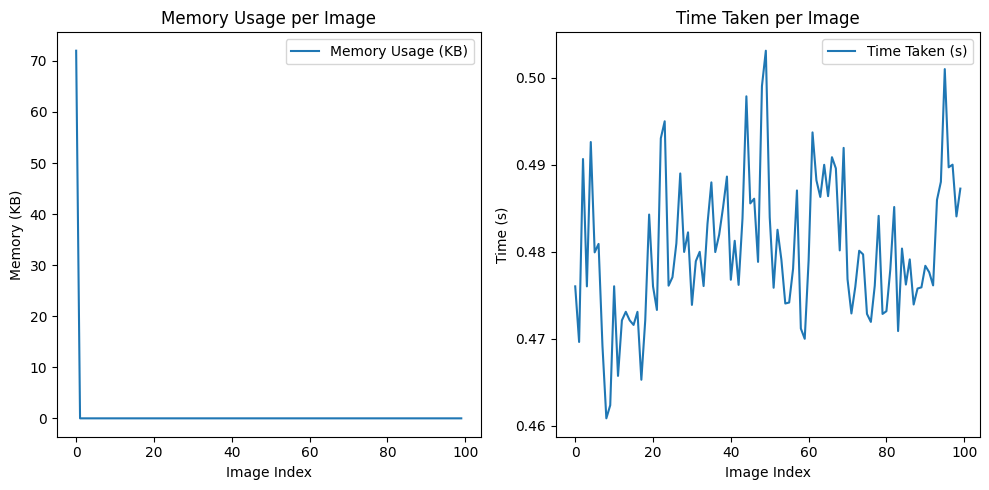

In [36]:
# Plotting memory and time
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(memory_usage, label='Memory Usage (KB)')
plt.xlabel('Image Index')
plt.ylabel('Memory (KB)')
plt.title('Memory Usage per Image')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_taken, label='Time Taken (s)')
plt.xlabel('Image Index')
plt.ylabel('Time (s)')
plt.title('Time Taken per Image')
plt.legend()

plt.tight_layout()
plt.show()

## Write in Excel

Note:
- write_row(row, column, data)
- write_column(row, column, data)
- worksheet.write(0, 1, "Hello")
- worksheet.write(0, 2, "World")

https://stackoverflow.com/questions/31909722/how-to-write-python-array-into-excel-spread-sheet

In [15]:
# Buka file Excel yang sudah ada
filepath = r"C:\Users\SMSK_Narinda\Desktop\Skripsi_Checkpoint_KNN_SVM_Dermnet\Testing_Result.xlsx"
workbook = load_workbook(filepath)
predictions_str = [pred[0] for pred in prediction]

# Tambahkan sheet baru
new_sheet_name = "Test_SVM_label"  # Ganti dengan nama sheet yang diinginkan
worksheet = workbook.create_sheet(title=new_sheet_name)

# Menulis data ke sheet baru
worksheet.append(["Image Number", "Image Name", "Memory Usage", "Time Taken", "Prediction"])  # Header
for i in range(len(img_num)):
    worksheet.append([img_num[i], img_name[i], memory_usage[i], time_taken[i], predictions_str[i]])

# Simpan workbook kembali
workbook.save(filepath)

In [ ]:
print(len(img_num))
print(len(img_name))
print(len(time_taken))
print(len(predictions_str))

## Simple Example

In [20]:
workbook = xlsxwriter.Workbook(r"C:\Users\SMSK_Narinda\Desktop\test_hasil.xlsx")
worksheet = workbook.add_worksheet()
predictions_str = [pred[0] for pred in prediction]

worksheet.write_column(1, 1, img_num)
worksheet.write_column(1, 2, img_name)
worksheet.write_column(1, 3, memory_usage)
worksheet.write_column(1, 4, time_taken)
worksheet.write_column(1, 5, predictions_str)

workbook.close()

In [ ]:
# for filename in os.scandir(img_test_path):
#             if filename.is_file():
#                 # Get image's path from object filename
#                 image_path = filename.path
                
#                 # Get image's filename
#                 image = filename
                
#                 # Read image from image_path 
#                 image = cv2.imread(image_path)
                
#                 # Get label from the subfolder name 
#                 label = classes.split(os.path.sep)[-1]
    
#                 # Use extract_color_histogram function
#                 # Features extraction from color histogram image 
#                 hist = extract_color_histogram(image)
    
#                 # Add to list
#                 features.append(hist)
#                 labels.append(label)

In [ ]:
for i in range (1,10):
    start_time = time.time()
    img_num.append(i)
    for y in range (1,10):
        memory.append(y)
    # duration.append('%.100f' % (time.time() - start_time))

In [ ]:
# print(memory)
# print(duration)